In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from math import log2
import psycopg2
import os

plt.style.use('https://gist.githubusercontent.com/peterphot/0d2645b0ced93c3cc71d31695ad1a5ae/raw/33cbe89d779b61ef5532272c5cdc0c1f2c56a357/matplotlibrc_dumbestwaytoconfigever')
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

In [ ]:


iv_df = _deepnote_execute_sql("""select
    *
from detect.interaction_vectors
where True
""", 'SQL_52793694_A2B5_4D65_AC5F_FD0AE09C38F6')
iv_df

,session_id,source_ip,session_start_local_time,doc_path,user_event,n,n_session_events,prop_interaction
0,02db048aaab07793c2165c37b7539e79,149.167.134.218,2022-03-23 20:06:14.793,/,view_index,1,5.0,0.2
1,02db048aaab07793c2165c37b7539e79,149.167.134.218,2022-03-23 20:06:14.793,/horses,search_horse,2,5.0,0.4
2,02db048aaab07793c2165c37b7539e79,149.167.134.218,2022-03-23 20:06:14.793,/horses,show_classes,0,5.0,0.0
3,02db048aaab07793c2165c37b7539e79,149.167.134.218,2022-03-23 20:06:14.793,/horses,show_distances,0,5.0,0.0
4,02db048aaab07793c2165c37b7539e79,149.167.134.218,2022-03-23 20:06:14.793,/horses,show_earnings,1,5.0,0.2
...,...,...,...,...,...,...,...,...
2515,ff15e3472f4cb464e317187694a3eb81,149.167.146.158,2022-03-26 15:23:28.077,/horses,view_horses,0,1.0,0.0
2516,ff15e3472f4cb464e317187694a3eb81,149.167.146.158,2022-03-26 15:23:28.077,/races,populate_cities_dropdown,0,1.0,0.0
2517,ff15e3472f4cb464e317187694a3eb81,149.167.146.158,2022-03-26 15:23:28.077,/races,search_race_info,0,1.0,0.0
2518,ff15e3472f4cb464e317187694a3eb81,149.167.146.158,2022-03-26 15:23:28.077,/races,search_race_result,0,1.0,0.0


In [ ]:
session_ids = []
n_vec = np.empty((0,iv_df['user_event'].nunique()), float)
prop_vec = np.empty((0,iv_df['user_event'].nunique()), float)

for su, row in iv_df.sort_values(by=['session_id', 'user_event']).groupby('session_id'):
    session_ids.append(su)
    n_vec = np.vstack((n_vec, row['n'].values))
    prop_vec = np.vstack((prop_vec, row['prop_interaction'].values))

ordered_events_list = row['user_event'].tolist()    

In [ ]:
n_components = np.arange(1, 30)
prop_models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(prop_vec) for n in n_components]
inter_models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(n_vec) for n in n_components]

In [ ]:
def plot_gmm_aicbics(ax, bics, aics, n_components, vec_name):
    plt.plot(n_components, bics, label='BIC')
    plt.plot(n_components, aics, label='AIC')
    plt.axvline(1+bics.index(min(bics)), linestyle = ':', label='BIC min')
    plt.text(1+bics.index(min(bics))+0.1, plt.gca().get_ylim()[-1]-300, str(bics.index(min(bics))))


    ax.legend(loc='best')
    ax.set_xlabel('n_components')
    ax.set_ylabel('score')
    ax.set_title(f'{vec_name} vectors')

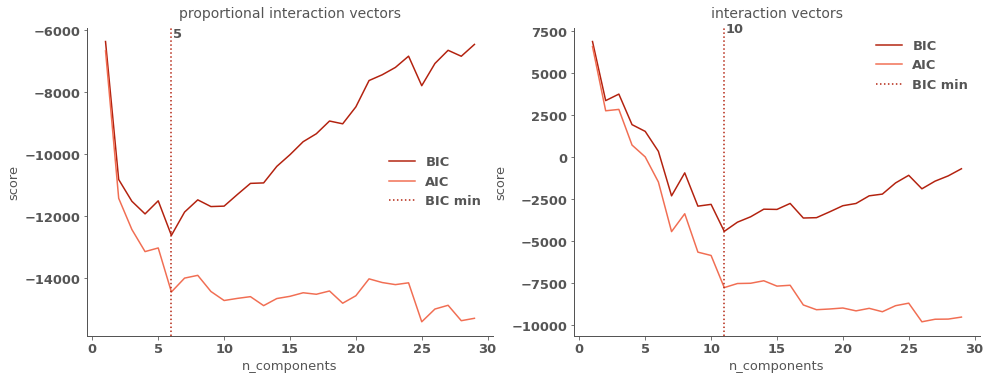

In [ ]:
plt.figure(figsize=(16,12))
bics = [m.bic(prop_vec) for m in prop_models]
aics = [m.aic(prop_vec) for m in prop_models]
plot_gmm_aicbics(plt.subplot(2, 2, 1), bics, aics, n_components, 'proportional interaction')

bics = [m.bic(n_vec) for m in inter_models]
aics = [m.aic(n_vec) for m in inter_models]
plot_gmm_aicbics(plt.subplot(2, 2, 2), bics, aics, n_components, 'interaction')

In [ ]:
prop_mod = GaussianMixture(6, covariance_type='full', random_state=0).fit(prop_vec)
vector_means = prop_mod.means_
preds = prop_mod.predict(prop_vec)
session_groups = {i:np.array(session_ids)[preds == i] for i in range(max(preds)+1)}

In [ ]:
mean_vectors_df = pd.DataFrame(vector_means, columns=ordered_events_list)
mean_vectors_df = mean_vectors_df.reset_index().rename(columns={'index':'cluster_id'})

In [ ]:
try:
    conn = psycopg2.connect(
        user=os.environ["RENDER_POSTGRES_USER"],
        password=os.environ["RENDER_POSTGRES_PASSWORD"],
        host=os.environ["RENDER_POSTGRES_HOST"],
        port=os.environ["RENDER_POSTGRES_PORT"],
        database=os.environ["RENDER_POSTGRES_DATABASE"])

    with conn.cursor() as cursor:
        cursor.execute("SELECT version();")
        record = cursor.fetchone()
        print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print ("Error while connecting to database", error)

You are connected to -  ('PostgreSQL 14.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44), 64-bit',)


In [ ]:
def create_table(conn, query):
    cursor = conn.cursor()
    cursor.execute(query)
    conn.commit()
    cursor.close()

def df_to_postgres(conn, df, table):    
    tuples = [tuple(x) for x in df.to_numpy()]
    cols = ','.join(list(df.columns))
    query  = "INSERT INTO %s(%s) VALUES(%s)" % (table, cols, ','.join(['%s']*len(df.columns)))    
    cursor = conn.cursor()
    try:
        cursor.executemany(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("write done")
    cursor.close()

In [ ]:
vector_mean_create = """DROP TABLE IF EXISTS detect.vector_means;
                        CREATE TABLE IF NOT EXISTS detect.vector_means (
                                cluster_id integer PRIMARY KEY
                                , populate_cities_dropdown float
                                , search_horse float
                                , search_race_info float
                                , search_race_result float
                                , show_classes float
                                , show_distances float
                                , show_earnings float
                                , show_places float
                                , show_start_gates float
                                , view_horses float
                                , view_index float
                                , view_races float
);"""    

create_table(conn, vector_mean_create)
df_to_postgres(conn, mean_vectors_df, 'detect.vector_means')

write done


In [ ]:
session_cluster_map = {'cluster_id':[], 'session_id':[]}

for k in session_groups:
    session_cluster_map['cluster_id'].extend(len(session_groups[k])*[k])
    session_cluster_map['session_id'].extend(session_groups[k])    

In [ ]:
# this is slow because I can not use copy_to due to how the hardware is set up on deepnote
cluster_sessions_create = """DROP TABLE IF EXISTS detect.cluster_sessions;
                        CREATE TABLE IF NOT EXISTS detect.cluster_sessions (
                                cluster_id integer
                                , session_id varchar(40)                            
);"""  

create_table(conn, cluster_sessions_create)
df_to_postgres(conn, pd.DataFrame(session_cluster_map), 'detect.cluster_sessions')

write done


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26f60d54-40d9-464e-9cf2-413fca0d13e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>